# Import necessary libraries

In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop


# Set up 

In [2]:
data_path = '/kaggle/input/google-speech-commands'

sample_rate = 16000
n_mfcc = 40  
mfcc_shape = (64, 64)

# List of classes
commands = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

# Data augmentation: Add noise
def add_noise(audio, noise_factor=0.005):
    noise = np.random.randn(len(audio))
    return audio + noise_factor * noise

# Data augmentation: Time shift
def time_shift(audio, shift_max=0.2):
    shift = int(np.random.uniform(-shift_max, shift_max) * len(audio))
    return np.roll(audio, shift)

# Load audio files and data 

In [3]:
def load_data(data_path, commands, augment=True):
    X, y = [], []
    for idx, command in enumerate(commands):
        command_path = os.path.join(data_path, command)
        for file in os.listdir(command_path):
            if file.endswith('.wav'):
                file_path = os.path.join(command_path, file)
                audio, _ = librosa.load(file_path, sr=sample_rate)
                
                # Apply data augmentation
                if augment:
                    audio_aug = add_noise(audio)
                    mfcc_aug = librosa.feature.mfcc(y=audio_aug, sr=sample_rate, n_mfcc=n_mfcc)
                    mfcc_aug = librosa.util.fix_length(mfcc_aug, size=mfcc_shape[1])
                    mfcc_aug = np.resize(mfcc_aug, mfcc_shape)
                    X.append(mfcc_aug)
                    y.append(idx)
                
                mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
                mfcc = librosa.util.fix_length(mfcc, size=mfcc_shape[1])
                mfcc = np.resize(mfcc, mfcc_shape)
                X.append(mfcc)
                y.append(idx)
    return np.array(X), np.array(y)

# Load data with augmentation
X, y = load_data(data_path, commands, augment=True)

# Normalize pixel values
X = X / np.max(X)

# Reshape data for CNN 
X = X.reshape(-1, mfcc_shape[0], mfcc_shape[1], 1)

# One-hot encode labels
y = to_categorical(y, num_classes=len(commands))

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# CNN Model

In [4]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(mfcc_shape[0], mfcc_shape[1], 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(commands), activation='softmax')
])

# Compile model
cnn_model.compile(optimizer=RMSprop(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-5)

# Train model
history = cnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, 
                        callbacks=[early_stopping, reduce_lr])

# Evaluate model
test_loss, test_accuracy = cnn_model.evaluate(X_val, y_val)
print(f'Test accuracy: {test_accuracy:.2f}')

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


I0000 00:00:1731450023.981204     111 service.cc:145] XLA service 0x7859d00037f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731450023.981255     111 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731450023.981261     111 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  29/1185 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.1125 - loss: 2.9335

I0000 00:00:1731450030.798082     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1185/1185 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.1285 - loss: 2.3402 - val_accuracy: 0.2874 - val_loss: 1.9180 - learning_rate: 1.0000e-04
Epoch 2/30
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.3160 - loss: 1.8799 - val_accuracy: 0.5064 - val_loss: 1.4880 - learning_rate: 1.0000e-04
Epoch 3/30
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.4636 - loss: 1.5161 - val_accuracy: 0.6148 - val_loss: 1.1562 - learning_rate: 1.0000e-04
Epoch 4/30
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5730 - loss: 1.2119 - val_accuracy: 0.6799 - val_loss: 1.0321 - learning_rate: 1.0000e-04
Epoch 5/30
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6538 - loss: 1.0007 - val_accuracy: 0.7666 - val_loss: 0.8219 - learning_rate: 1.0000e-04
Epoch 6/30
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7066 - loss: 0.8573 - val_accuracy: 0.7803 - val_loss: 0.8017 - learning_rate: 1.0000e-04
Epoch 7/30
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accur

## Plot training history for CNN

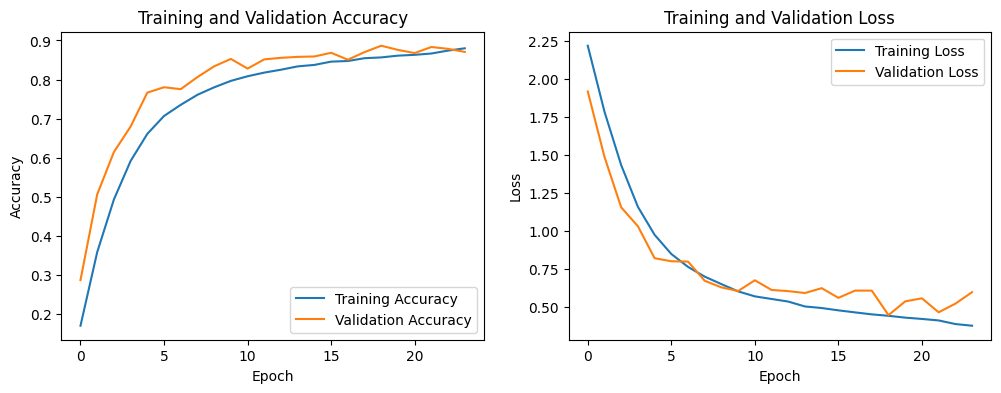

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


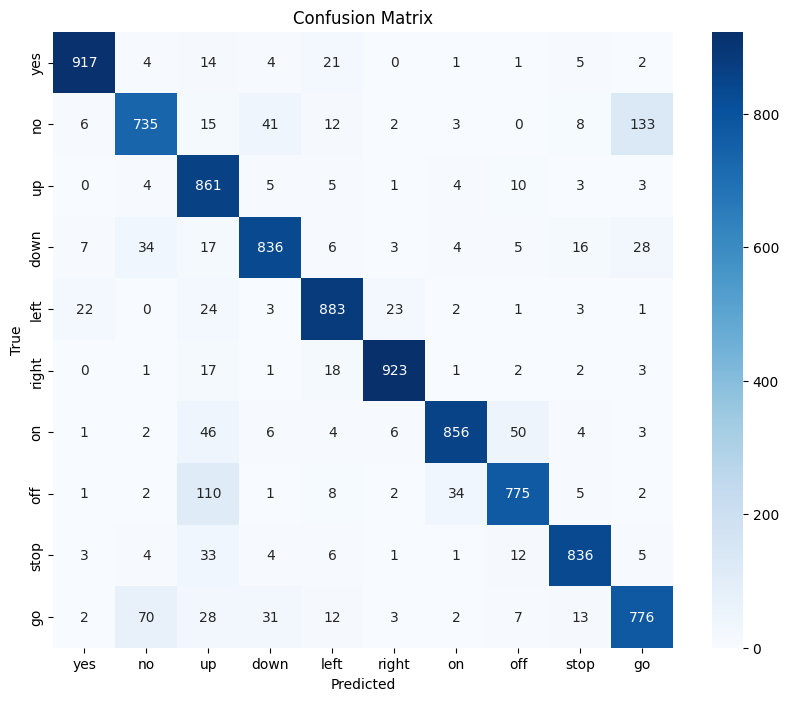

              precision    recall  f1-score   support

         yes       0.96      0.95      0.95       969
          no       0.86      0.77      0.81       955
          up       0.74      0.96      0.84       896
        down       0.90      0.87      0.89       956
        left       0.91      0.92      0.91       962
       right       0.96      0.95      0.96       968
          on       0.94      0.88      0.91       978
         off       0.90      0.82      0.86       940
        stop       0.93      0.92      0.93       905
          go       0.81      0.82      0.82       944

    accuracy                           0.89      9473
   macro avg       0.89      0.89      0.89      9473
weighted avg       0.89      0.89      0.89      9473



In [5]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

# Predict and evaluate with Confusion Matrix
y_pred = np.argmax(cnn_model.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=commands, yticklabels=commands)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=commands))

# ANN Model

In [6]:
ann_model = Sequential([
    Flatten(input_shape=(mfcc_shape[0], mfcc_shape[1])),  
    Dense(128, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(commands), activation='softmax')  
])

# Compile the ANN model
ann_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-5)

# Train ANN model
history_ann = ann_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, 
                            callbacks=[early_stopping, reduce_lr])

# Evaluate the ANN model
test_loss_ann, test_accuracy_ann = ann_model.evaluate(X_val, y_val)
print(f'ANN Test accuracy: {test_accuracy_ann:.2f}')

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.3068 - loss: 1.9202 - val_accuracy: 0.5782 - val_loss: 1.2700 - learning_rate: 0.0010
Epoch 2/30
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4842 - loss: 1.4531 - val_accuracy: 0.6387 - val_loss: 1.1325 - learning_rate: 0.0010
Epoch 3/30
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5282 - loss: 1.3291 - val_accuracy: 0.6622 - val_loss: 1.0176 - learning_rate: 0.0010
Epoch 4/30
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5536 - loss: 1.2585 - val_accuracy: 0.6609 - val_loss: 1.0105 - learning_rate: 0.0010
Epoch 5/30
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5723 - loss: 1.2294 - val_accuracy: 0.7033 - val_loss: 0.9001 - learning_rate: 0.0010
Epoch 6/30
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5856 - loss: 1.1965 - val_accuracy: 0.6978 - val_loss: 0.9122 - learning_rate: 0.0010
Epoch 7/30
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5918 - 

## Plot training history for ANN

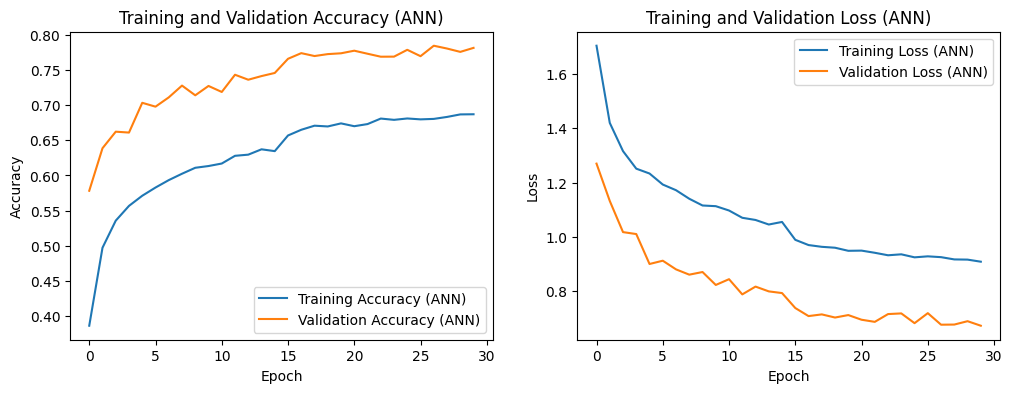

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


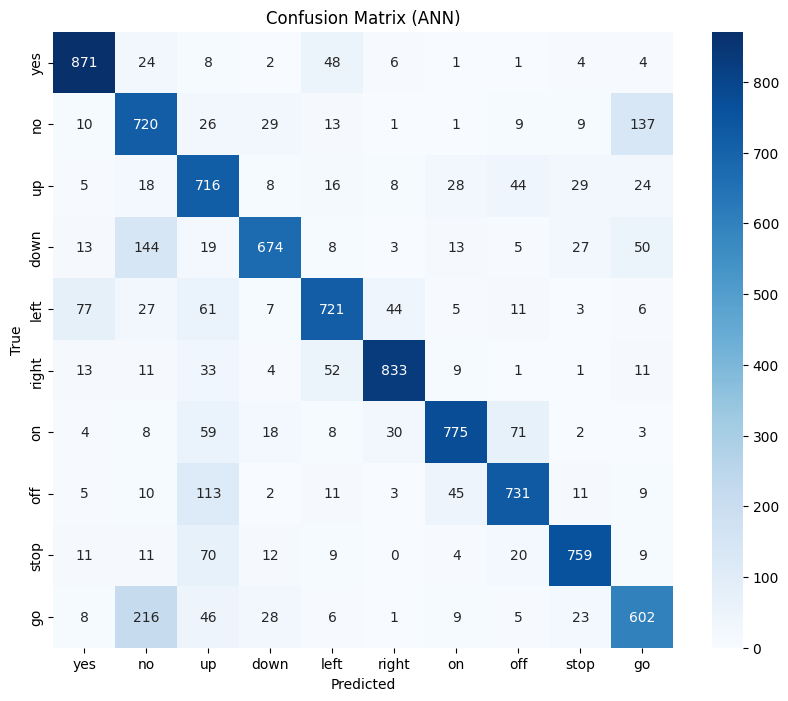

              precision    recall  f1-score   support

         yes       0.86      0.90      0.88       969
          no       0.61      0.75      0.67       955
          up       0.62      0.80      0.70       896
        down       0.86      0.71      0.77       956
        left       0.81      0.75      0.78       962
       right       0.90      0.86      0.88       968
          on       0.87      0.79      0.83       978
         off       0.81      0.78      0.80       940
        stop       0.87      0.84      0.86       905
          go       0.70      0.64      0.67       944

    accuracy                           0.78      9473
   macro avg       0.79      0.78      0.78      9473
weighted avg       0.79      0.78      0.78      9473



In [7]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_ann.history['accuracy'], label='Training Accuracy (ANN)')
plt.plot(history_ann.history['val_accuracy'], label='Validation Accuracy (ANN)')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (ANN)')

plt.subplot(1, 2, 2)
plt.plot(history_ann.history['loss'], label='Training Loss (ANN)')
plt.plot(history_ann.history['val_loss'], label='Validation Loss (ANN)')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (ANN)')
plt.show()

# Confusion Matrix and Classification Report for ANN
y_pred_ann = np.argmax(ann_model.predict(X_val), axis=1)
y_true_ann = np.argmax(y_val, axis=1)

cm_ann = confusion_matrix(y_true_ann, y_pred_ann)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_ann, annot=True, fmt="d", cmap="Blues", xticklabels=commands, yticklabels=commands)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (ANN)')
plt.show()

# Classification Report for ANN
print(classification_report(y_true_ann, y_pred_ann, target_names=commands))